## Projekt iz predmeta Uvod u znanost o podatcima 2021/2022
https://www.fer.unizg.hr/predmet/uuzop


------------------------------

### Implementacija algoritama strojnog učenja u svrhu predviđanje srčanog zastoja

Author: Mario Tropčić

------------------------------

Cilj ovog projekta je replikacija i proširenje dobivenih rezultata opisanih u članku <b>"Implementation of Machine Learning Model to Predict Heart Failure Disease" </b>(https://pdfs.semanticscholar.org/a74f/d8c51251e8c6126a1527e545bd78860a10f9.pdf).

Prije nego što počnemo s detaljnijom analizom podataka i reprodukcijom rezultata, ukratko ćemo objasniti koja su to vrsta istraživanja provedena u promatranom članku i to na temlju nekoliko kriterija. S obzirom da se istraživanje u radu oslanja na teoriju radi stvaranja praktičnog znanstvenog znanja (određivanje šansi srčanog zastoja), možemo reći da se ovdje radi o <b>primjenjenom istraživanju</b>. Ukoliko nas zanima tip istraživanja prema dubini, primjećujemo da je svrha istraživanja zapravo otkriti odnos između različitih simptoma pacijenta i šansi srčanog zastoja, stoga je razumno pretpostaviti da je provedeno istraživanje <b>korelacijsko</b>. Gledajući vrstu podataka koje smo koristili zaključujemo da je riječ o <b>kvantitativnom istraživanju</b>. Naime, kvantitativno istraživanje prvenstveno istražuje fenomen kvantitativnim prikupljanjem podataka i korištenjem matematičkih, statističkih i računalno potpomognutih alata za njihovo mjerenje, a to je upravo ono što je rađeno u radu i ono na što ćemo se mi oslanjati u nastavku. Dakle, koristiti ćemo mjerljive varijable kako bi na temlju njih razvili model koji će predviđati šanse srčanog zastoja kod pojedinaca. Sljedeći kriterij koji nas zanima je stupanj manipulacije varijablama. Primjećujemo da istraživač u radu ne intervenira izravno već svoje sudjelovanje ograničava isključivo na mjerenje varijabli potrebnih za istraživanje te na temlju toga zaključujemo da se radi o <b>promatračkoj vrsti istraživanja</b>. Prema vrsti zaključka, provedeno istraživanje pripada <b>deduktivnom tipu istraživanja</b>. Deduktivana istraživanja su prvenstveno povezana s kvantitativnim istraživanjima, a stvarnost se objašnjava općim zakonima koji upućuju na određene zaključke. Naime pri izradi našeg modela mi indirektno nastojimo pronaći veze između varijabli koje imamo na raspolaganju i šansi srčanog zastoja, kako bi uspješno radili predviđanja na neviđenim primjerima. S obzirom da u istraživanju promtramo pojedince u određenom trenutku, prema vremenu provedbe radi se o <b>studiji presjeka</b>, a gledajući kriterije izvora informacije i načina prikupljanja podataka u članku, vidimo da je riječ o <b>sekundarnom</b> odnosno <b>dokumentarnom istraživanju</b>. Naime podatci kojima mi raspolažemo prikupljeni su od strane drugih istraživača tijekom duljeg vremenskog razdoblja i organizirani su u bazu podataka koja sadrži sve informacije potrebne za naš daljni rad, također samim time omogućen nam je sustavan pregled postojećih izvora informacija.

Podatci s kojima radimo su javno dostupne medicinske informacije pacijenata koji su pristali na njihovo djeljenje u istraživačke svrhe putem interneta, stoga možemo reći da je <b>dokumentarno istraživanje</b> izabrano kao metoda prikupljanja podataka za ovaj rad.

Izravnu informaciju o tome kako su podatci prikupljeni nemamo, međutim dataset s kojim radimo je dobro poznati skup podataka prikupljen od strane različitih istraživača i korišten u mnogim dosadašnjim istraživanjima, stoga je razumno pretpostaviti da su svi podatci prikupljeni u skladu s <b>istraživačkom etikom</b>.

### Učitavanje potrebnih biblioteka

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Učitavanje potrebnih podataka

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# reading csv file
data =  pd.read_csv('heart.csv', sep=",")
heart_data = data.copy()
display(heart_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Pojašnjenja značajki:
 - <b>Age</b> - starost pacijenta u godinama
 - <b>Sex</b> - spol pacijenta (0 označava ženski spol, a 1 muški)
 - <b>CP</b> - pacijentov tip boli u prsima pri primitku u bolnicu (0 - tipična angina, 1 - atipična angina, 2 - neanginalna bol, 3 - asimptomatična bol)
 - <b>RestBP</b> - vrijednost krvnog tlaka pacijenta pri primitku u bolnicu (vrijednosti između 94 i 200)
 - <b>Chol</b> - pacijentova razina kolesterola pri primitku u bolnicu (vrijednosti između 126 i 564)
 - <b>FBS</b> - razina šećera u krvi bolesnika na prazan želudac (0 ako je količina ispod 120mg/dl, 1 inače)
 - <b>RestECG</b> - vrijednost ECG (0 - normalan, 1 - ST-T, 2 - hipertrofija)
 - <b>Thalach</b> - pacijentov maksimalan broj okucaja srca u minuti pri primitku u bolnicu (vrijednosti između 71 i 202)
 - <b>Exang</b> - parametar koji otkriva urokuje li tjelovježba anginu (0 za ne, 1 za da)
 - <b>OldPeak</b> - atribut koji označava razinu ST depresije induciranu tjelovježbom (vrijednosti između 0 i 6.2)
 - <b>Slope</b> - pacijentovo stanje tijekom tjelovježbe (0, 1, 2)
 - <b>CA</b> - status fluroskopije odnosno količina obojanih krvnih žila tijekom testa (0, 1, 2, 3)
 - <b>Thal</b> - rezultati testa s Talijem (0, 1, 2, 3)
 - <b>Target</b> - ciljani razred, oznaka koja pokazuje ima li osoba veliku vjerojatnost od srčanog zastoja ili ne (0 za ne, 1 za da)

Sljedeći korak je provjera našeg skupa podataka kako bi vidjeli je li on potpun, odnosno postoje li podaci čije vrijednosti nedostaju.

In [3]:
display(heart_data.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Primjećujemo da naš skup podataka nema značajki čije vrijednosti nedostaju te također vidimo da su sve vrijednosti numeričke stoga bez problema možemo nastaviti s daljnjom analizom.

In [4]:
display(heart_data.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Iz opisa podataka možemo zaključiti da nisu sve vrijednosti atributa unutar zadanih ograničenja. Konkretno za diskretnu značajku <b>CA </b> vidimo odstupanje od maksimalne zadane vrijednosti, stoga je potrebno popraviti naš skup podataka. Konkretno za atribut <b>CA </b> sve vrijednosti koje prelaze maksimalnu zadanu vrijednost ćemo ograničiti na pretpostavljenu vrijednost. Time smo osigurali da je naš dataset potpun i ispravan.

In [5]:
heart_data.loc[heart_data.ca > 3,'ca'] = 3

Sljedeći korak u našoj analizi podataka je njihova vizualizacija, te ćemo na temelju toga vidjeti kako se naši podatci ponašaju te koje pretpostavke možemo donijeti.

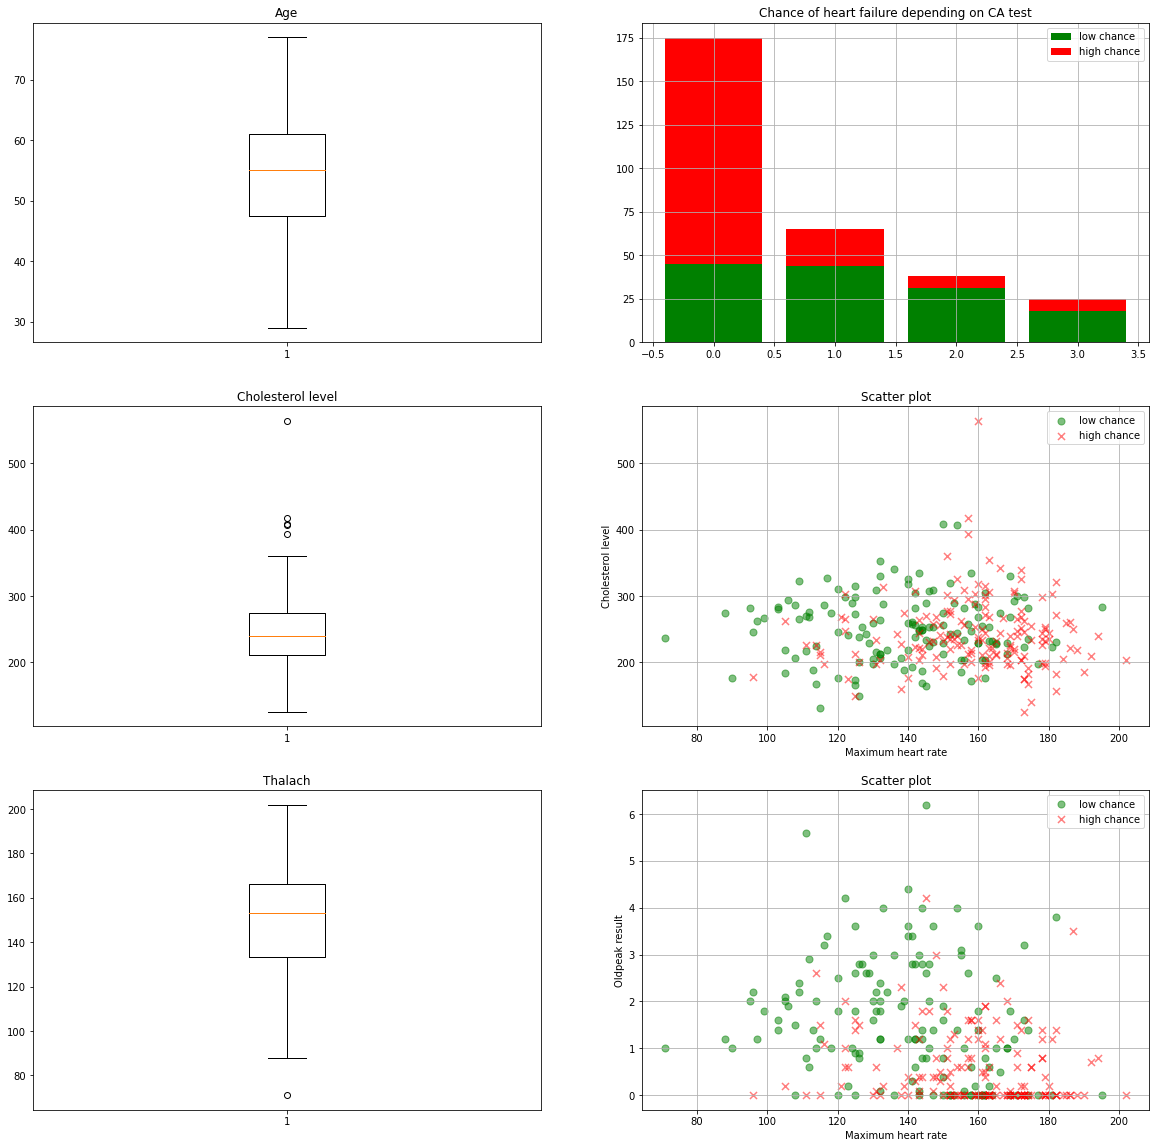

In [6]:
fig, ax = plt.subplots(3,2, figsize=(20,20)) 

ax[0,0].boxplot(heart_data.age)
ax[0,0].set_title('Age')

ax[1,0].boxplot(heart_data.chol)
ax[1,0].set_title('Cholesterol level')

ax[2,0].boxplot(heart_data.thalach)
ax[2,0].set_title('Thalach')

count_per_thal_low = heart_data.loc[heart_data.target == 0,:].groupby('ca').count().loc[:,'age'].values
count_per_thal_high = heart_data.loc[heart_data.target == 1,:].groupby('ca').count().loc[:,'age'].values
title_name = heart_data.groupby('ca').count().index.values

ax[0,1].bar(title_name, count_per_thal_low, color='green', label='low chance')
ax[0,1].bar(title_name, count_per_thal_high, color='red', label='high chance', bottom=count_per_thal_low)
ax[0,1].legend(loc='best')
ax[0,1].set_title('Chance of heart failure depending on CA test')
ax[0,1].grid()

ax[1,1].scatter(heart_data.loc[heart_data.target == 0,'thalach'], heart_data.loc[heart_data.target == 0,'chol'], s=50, alpha=0.5, c='g', label='low chance')
ax[1,1].scatter(heart_data.loc[heart_data.target == 1,'thalach'], heart_data.loc[heart_data.target == 1,'chol'], s=50, alpha=0.5, marker='x', c='r', label='high chance')
ax[1,1].set_xlabel('Maximum heart rate')
ax[1,1].set_ylabel('Cholesterol level')
ax[1,1].set_title('Scatter plot')
ax[1,1].legend(loc='best')
ax[1,1].grid()

ax[2,1].scatter(heart_data.loc[heart_data.target == 0,'thalach'], heart_data.loc[heart_data.target == 0,'oldpeak'], s=50, alpha=0.5, c='g', label='low chance')
ax[2,1].scatter(heart_data.loc[heart_data.target == 1,'thalach'], heart_data.loc[heart_data.target == 1,'oldpeak'], s=50, alpha=0.5, marker='x', c='r', label='high chance')
ax[2,1].set_xlabel('Maximum heart rate')
ax[2,1].set_ylabel('Oldpeak result')
ax[2,1].set_title('Scatter plot')
ax[2,1].legend(loc='best')
ax[2,1].grid()

Na prikazanim boxplotovima možemo primjetiti nekoliko primjera koje možemo okarakterizirati kao stršeće vrijednosti na temelju značajki <b> Thalach </b> i <b>Chol</b>. Postoje mnogi načini kako se nositi sa stršećim vrijednostima, međutim u ovom projektu ćemo te primjere izbaciti iz našeg skupa. Također analizom ostalih dijagrama možemo donijeti određene pretpostavke o podatcima. Konkretno na temelju stupčastog dijagrama možemo zaključiti da osobe koje postižu niske rezultate prilikom CA testiranja, odnosno imaju malu količinu obojanih krvnih žila prilikom testa, imaju veću šansu od srčanog zastoja. Iz preostala dva grafa vidimo šanse srčanog zastoja u ovisnosti o broju otkucaja srca i rezultatima Oldpeak testa odnosno razini kolesterola. Primjećujemo da osobe s velikim brojem otkucaja i visokom razinom kolesterola imaju veću šansu od srčanog zastoja u odnosu na alternativu. Dok bi pri analizi drugog grafa mogli reći, protivno našoj intuiciji, da osobe s niskim rezultatom Oldpeak testa i visokim brojem otkucaja srca imaju visoku šansu od srčanog zastoja. Naime, medicinski gledano niski rezultati Oldpeak testiranja ukazuju na to da je pacijent u dobrom stanju. Iz toga možemo zaključiti da visoki broj otkucaja srca ima važniju ulogu pri otkrivanju ima li osoba veću šansu od srčanog zastoja u odnosu na Oldpeak test. 

In [7]:
# Izbacivanje stršećih vrijednosti

heart_data = heart_data.drop(heart_data.index[heart_data['chol'] == heart_data['chol'].max()], axis=0)
heart_data = heart_data.drop(heart_data.index[heart_data['thalach'] == heart_data['thalach'].min()], axis=0)

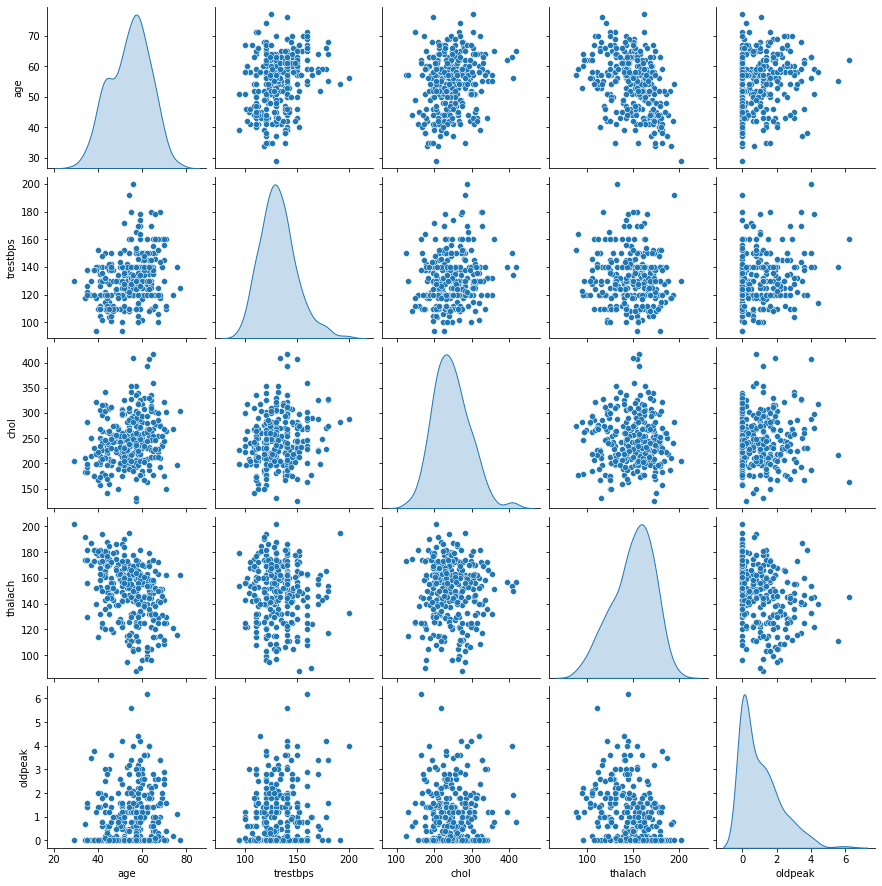

In [8]:
sns.pairplot(heart_data.loc[:,['age', 'trestbps', 'chol', 'thalach', 'oldpeak']], diag_kind='kde')
plt.show()

Iz matrice raspršenja možemo primjetiti da ne postoji značajna linearna korelacija između bilo koje dvije značajke. Krvni tlak, razina kolesterola i oldpeak (ST depresija) pokazuju slabu pozitivnu linearnu korelaciju s dobi dok maksimalni postignuti broj otkucaja srca pokazuje blagu negativnu korelaciju s dobi. Naime, nama odgovara što ne postoji zavisnost između pojedinih značajki jer samim time naši modeli strojnog učenja će bolje generalizirati te će davati bolje predikcije za neviđene podatke.

Iz iskustva znamo da će naši modeli imati veću točnost što je volumen podataka veći stoga ćemo u skladu s uputama u znanstvenom radu pokušati umjetno generirati nove podatke na način da nasumično povećavamo ili smanjujemo kontinuirane značajke nasumično odabranog primjera kojeg imamo na raspolaganju i tako generiramo nove primjere kako bi povećali njihov ukupan broj.

In [9]:
df = heart_data.to_numpy()
new_data = heart_data.to_numpy()
number_of_new_examples = 900
indices_of_continuous_variables = [0, 3, 4, 7, 9]

def modify_new_example(example, i):
    
    if random.randint(0, 1) == 1:
        p = random.randint(80, 100)
        new_example[i] = new_example[i] + int(new_example[i] * ((1-p) / 100))
    else:
        p = random.randint(80, 100)
        new_example[i] = int(new_example[i] * (p / 100))
            
    return example

for i in range(number_of_new_examples):
    n = random.randint(0, df.shape[0] - 1)
    new_example = df[n].copy()
    for index in indices_of_continuous_variables:
        new_example = modify_new_example(new_example, index)
    new_data = np.vstack([new_data, new_example])

# Razdvajanje značajki od ciljanog razreda; s dodavanjem umjetnih primjera

X_heart = new_data[:,:-1]
y_heart = new_data[:,-1]

Sljedeći korak je izgradnja našeg modela učenja, kako je opisano u radu, modeli strojnog učenja koje ćemo koristit u ovom projektu bit će: <b>Naïve Bayes</b>, <b>Decision Tree</b>, <b>Random Forest</b>, <b>Logistic Regression</b> i <b>Support Vector Machine</b>.

In [10]:
# Razdvajanje značajki od ciljanog razreda; bez dodavanja umjetnih primjera

# X_heart = heart_data.loc[:, heart_data.columns != 'target']
# y_heart = heart_data.loc[:, 'target']
# X_heart = X_heart.to_numpy()
# y_heart = y_heart.to_numpy()

In [11]:
# Izgradnja modela

class ProjectClassifier:
    
    def __init__(self, splits=10, repeats=10):
        self.rkf  = RepeatedKFold(n_splits=splits, n_repeats=repeats)
        self.confusion_matrices = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
        self.scores = []
        self.X = None
        self.y = None
        self.models_names = ['Naïve Bayes', 'Decision Tree', 'Random Forest', 'LogisticReg', 'SupportVM']
        
        self.bnb = make_pipeline(StandardScaler(), BernoulliNB())
        self.dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        self.rfc = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=10, random_state=0))
        self.reg = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
        self.svc = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
        
        self.models = [self.bnb, self.dt, self.rfc, self.reg, self.svc]
        
    def get_confusion_matrices(self):
        for name, matrix in zip(self.models_names, self.confusion_matrices):
            m = np.round(matrix/10)
            print('\033[1m' + name +  '\tTrue(1)  \tTrue(0)  \tClass Precision \033[0m')
            print('\033[1m' + 'Prediction(1)' + '\033[0m \t{0}  \t\t{1}  \t\t{2:.2f}%'.format(int(m[0,0]), int(m[0,1]), 100*(m[0,0]/(m[0,0] + m[0,1]))))
            print('\033[1m' + 'Prediction(0)' + '\033[0m \t{0}  \t\t{1}  \t\t{2:.2f}%'.format(int(m[1,0]), int(m[1,1]), 100*(m[1,1]/(m[1,1] + m[1,0]))))
            print('\033[1m' + 'Class Recall' + '\033[0m \t{0:.2f}%  \t{1:.2f}%\n'.format(100*(m[0,0]/(m[0,0] + m[1,0])), 100*(m[1,1]/(m[1,1] + m[0,1]))))
            
    def models_accuracy(self):
        for model in self.models:
            self.scores.append(cross_val_score(model, self.X, self.y, scoring='accuracy', cv=self.rkf, n_jobs=-1))
            
        print('\033[1m' + 'Technique \tProject \tStudy' + '\033[0m')
        for name, score, study in zip(self.models_names, self.scores, [87.27, 93.19, 89.14, 87.36, 92.30]):
            print('\033[1m' + name + '\033[0m \t{0:.2f}% \t\t{1}%'.format(100*(np.mean(score)), study))
    
    def fit_predict(self, X, y):
        
        self.X = X
        self.y = y
        
        for train_index, test_index in self.rkf.split(X):
            X_train, y_train = self.X[train_index], self.y[train_index]
            X_test, y_test = self.X[test_index], self.y[test_index]
            matrix_index = 0
            for model in self.models:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                self.confusion_matrices[matrix_index] +=confusion_matrix(y_test, y_pred)
                matrix_index = matrix_index + 1

In [12]:
projectClassifier = ProjectClassifier()
projectClassifier.fit_predict(X_heart, y_heart)
projectClassifier.get_confusion_matrices()
projectClassifier.models_accuracy()

Naïve Bayes	True(1)  	True(0)  	Class Precision 
Prediction(1) 	441  		93  		82.58%
Prediction(0) 	76  		591  		88.61%
Class Recall 	85.30%  	86.40%

Decision Tree	True(1)  	True(0)  	Class Precision 
Prediction(1) 	467  		67  		87.45%
Prediction(0) 	67  		600  		89.96%
Class Recall 	87.45%  	89.96%

Random Forest	True(1)  	True(0)  	Class Precision 
Prediction(1) 	482  		52  		90.26%
Prediction(0) 	35  		632  		94.75%
Class Recall 	93.23%  	92.40%

LogisticReg	True(1)  	True(0)  	Class Precision 
Prediction(1) 	426  		108  		79.78%
Prediction(0) 	65  		602  		90.25%
Class Recall 	86.76%  	84.79%

SupportVM	True(1)  	True(0)  	Class Precision 
Prediction(1) 	464  		70  		86.89%
Prediction(0) 	45  		622  		93.25%
Class Recall 	91.16%  	89.88%

Technique 	Project 	Study
Naïve Bayes 	85.89% 		87.27%
Decision Tree 	89.28% 		93.19%
Random Forest 	92.80% 		89.14%
LogisticReg 	85.76% 		87.36%
SupportVM 	90.20% 		92.3%


Uspoređujući podatke dobivene u projektu s onima u znanstvenom radu primjećujemo da dolazi do sitnog odstupanja u točnosti svakog modela između dva rada u obliku od nekoliko posto. Razlog tih odstupanja možemo pronaći u različitim metodama korištenim za generiranje novih podataka, kao i u tome da je u znanstvenom radu za izgradnju modela i klasifikaciju primjera korištena programska platforma RapidMiner. S obzirom na te razlike i veliku točnost modela razvijenih u ovom projektu možemo reći da su rezultati postignuti u <b>Implementation of Machine Learning Model to Predict Heart Failure Disease</b> uspješno reproducirani.